In [1]:
from intelligent_placer_lib.placer import *


In [2]:
im = get_images('tests')



**Посмотрим сначала на сегментацию:**

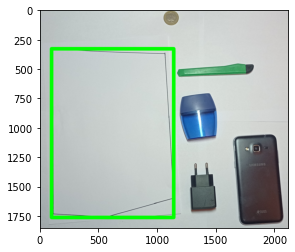

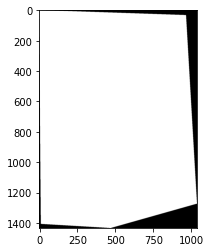

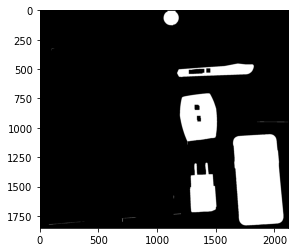

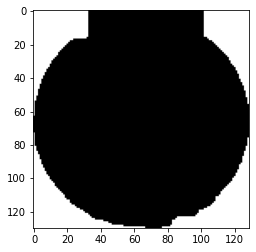

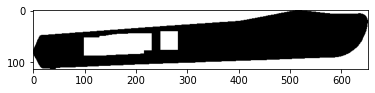

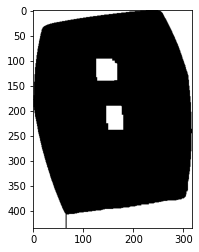

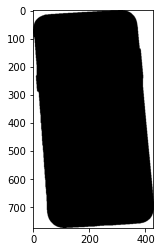

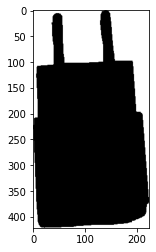

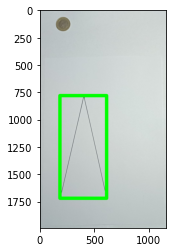

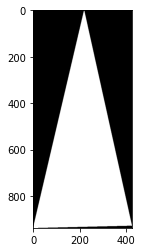

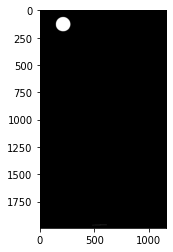

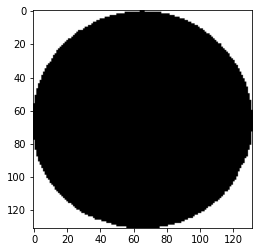

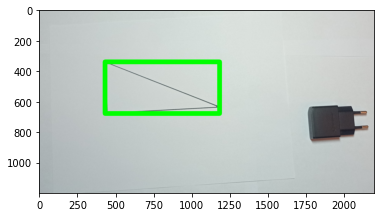

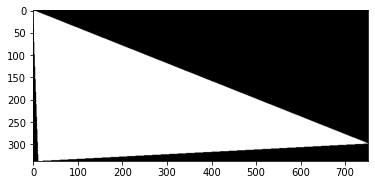

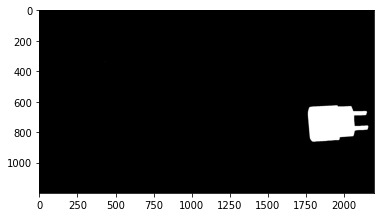

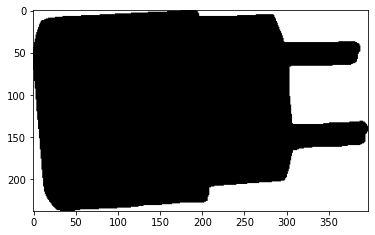

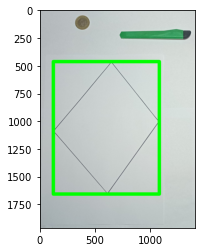

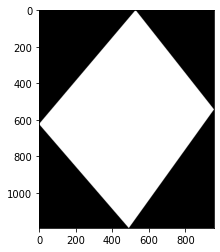

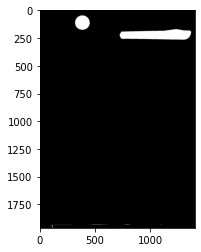

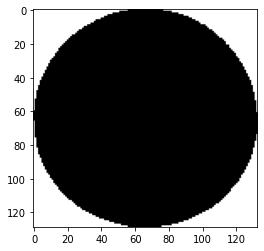

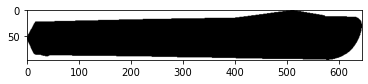

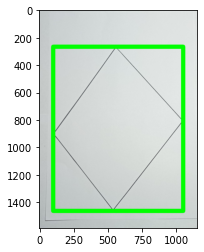

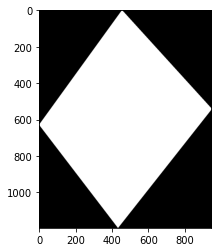

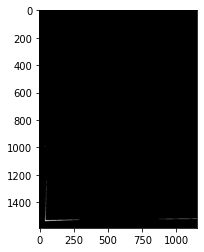

False


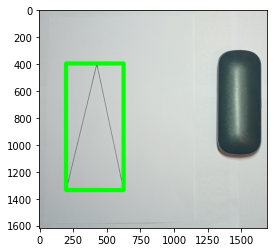

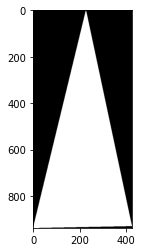

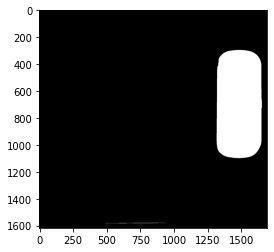

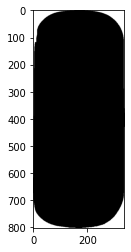

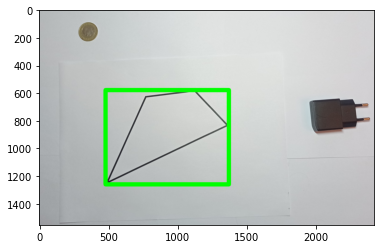

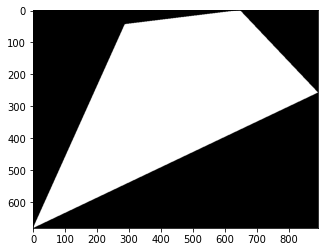

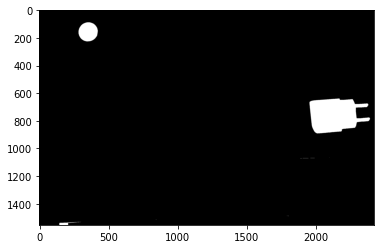

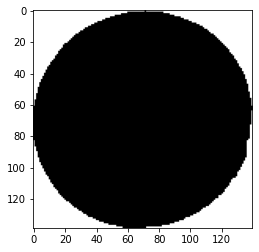

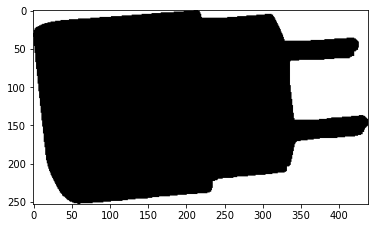

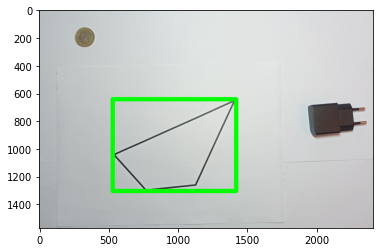

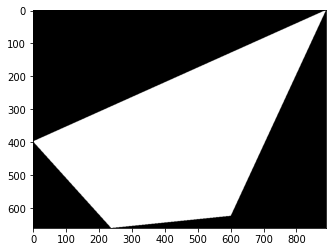

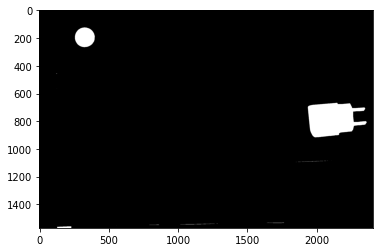

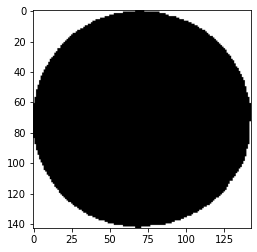

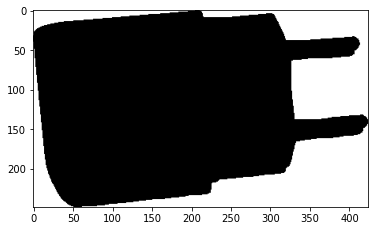

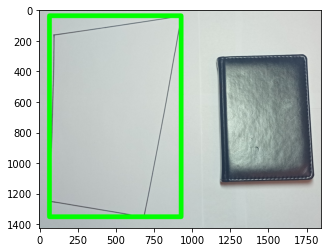

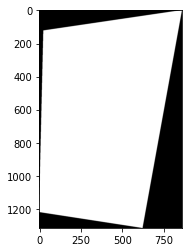

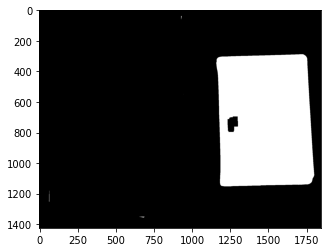

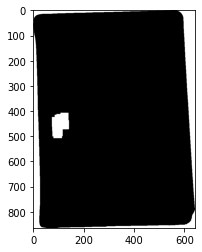

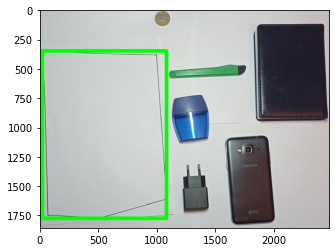

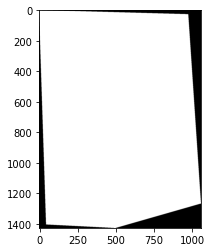

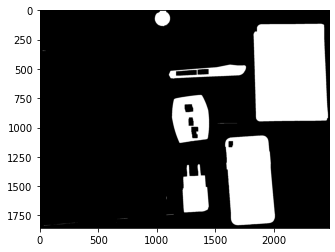

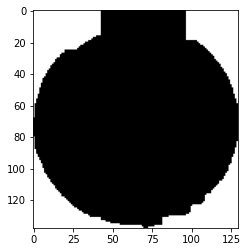

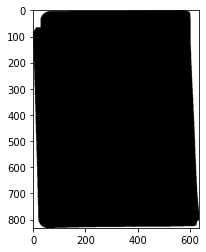

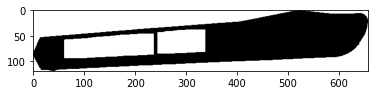

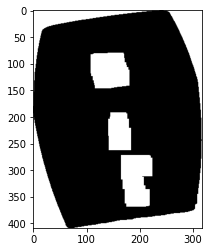

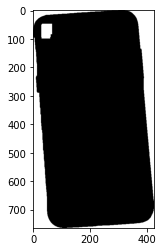

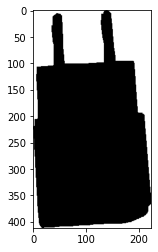

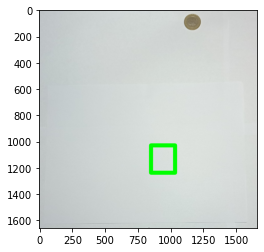

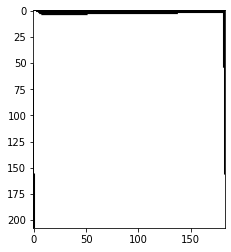

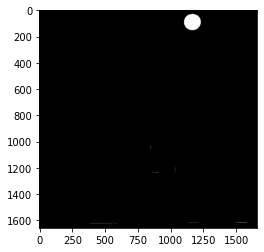

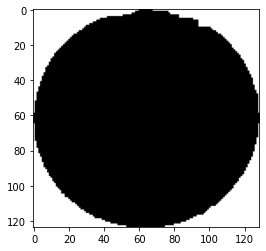

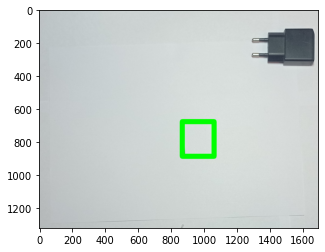

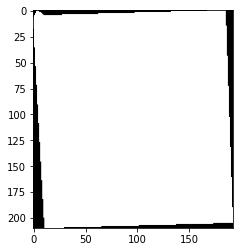

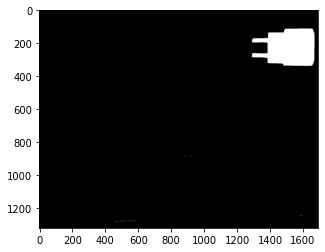

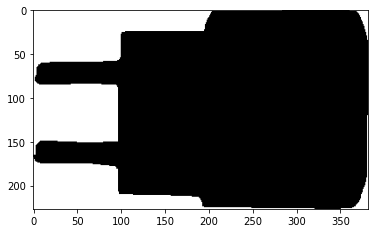

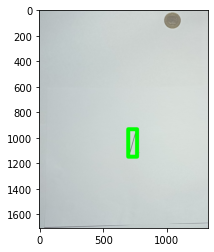

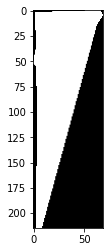

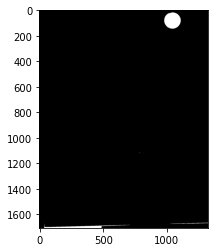

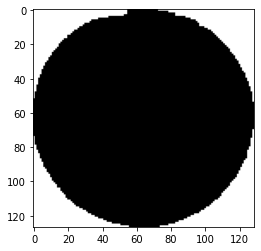

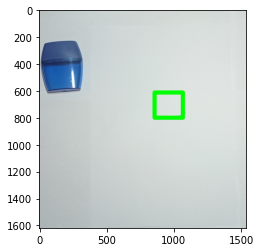

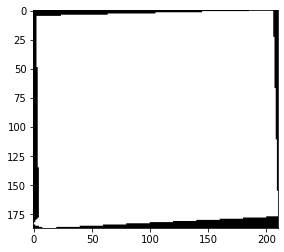

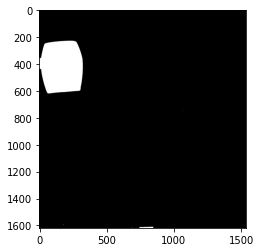

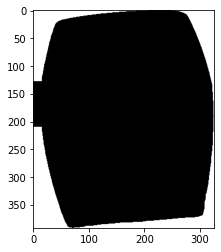

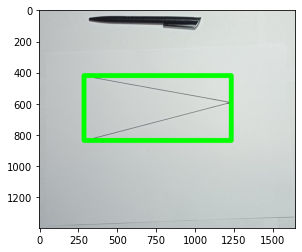

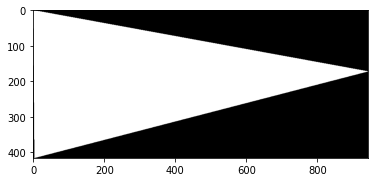

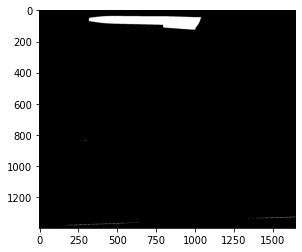

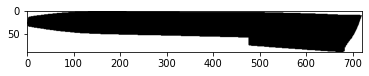

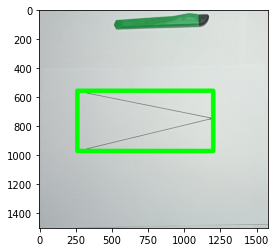

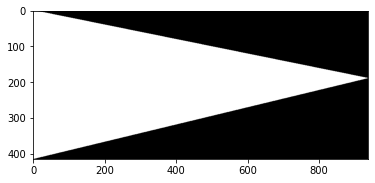

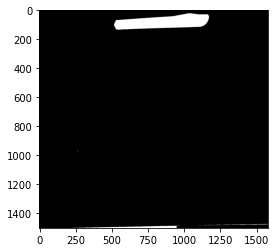

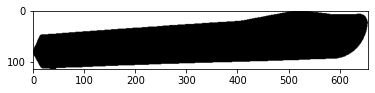

In [3]:
for image in im:
    # Найдем ограничивающую рамку для многоугольника и содержащее только его изображение
    box, rect = find_poly(image)
    
    # Если прямоугольник не нашелся - нам некуда складывать предметы
    if rect is None:
        print("False")
        continue
    
    x,y,w,h = box
    #Нарисуем рамку для наглядности
    img = image.copy()
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),30)
    plt.imshow(img)
    plt.show()
    # Только многоугольник:
    plt.imshow(rect, cmap='gray')
    plt.show()
    
    #Отфильтруем теперь только предметы
    wf = filter_items(image, box)
    plt.imshow(filter_items(image, box), cmap='gray')
    plt.show()
    #Наконец найдем маски для них
    masks, _ = get_masks(wf)
    
    for msk in masks:
        plt.imshow(~msk, cmap='gray')
        plt.show()
    

**Теперь на результаты работы размещения объектов в многоугольник**

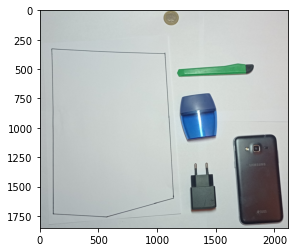

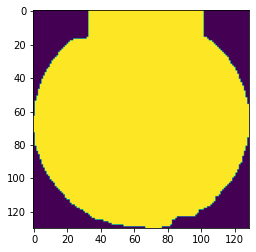

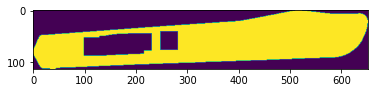

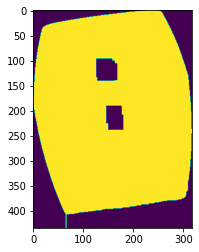

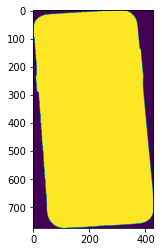

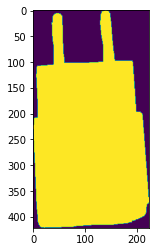

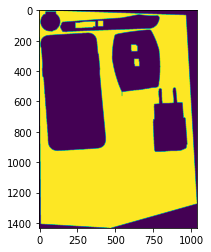

Answer: True


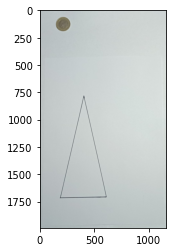

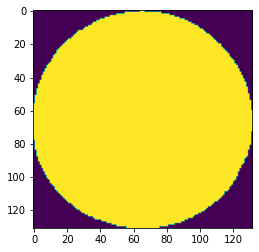

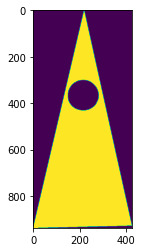

Answer: True


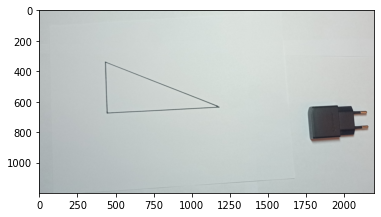

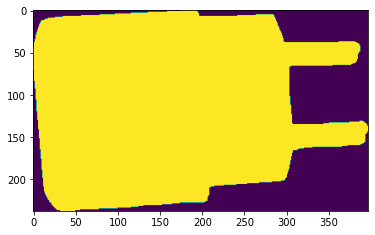

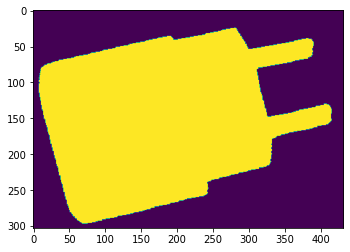

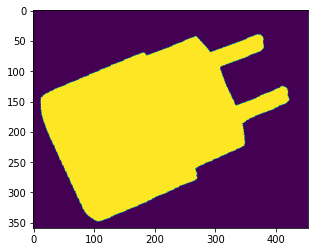

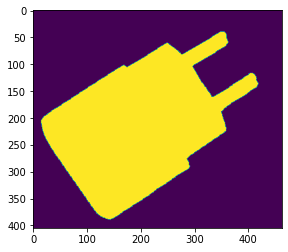

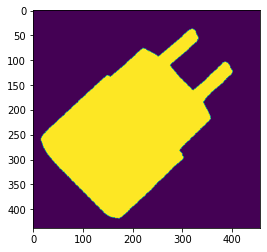

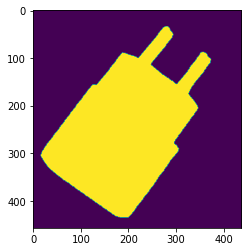

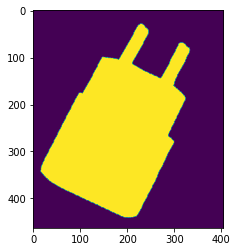

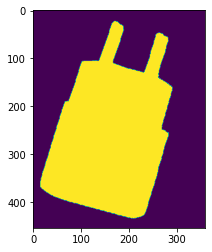

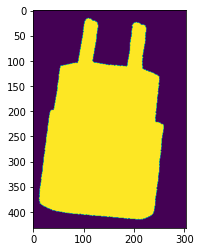

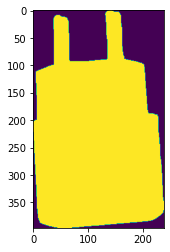

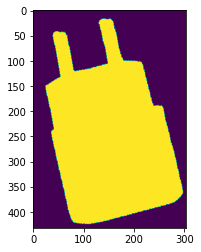

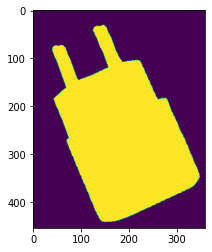

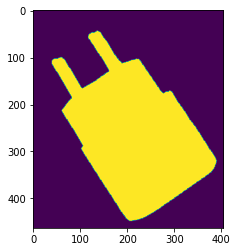

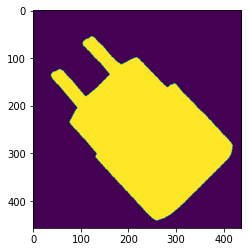

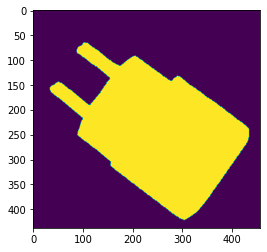

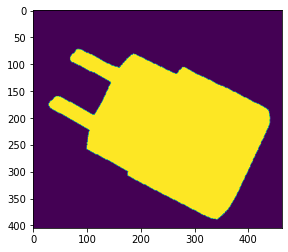

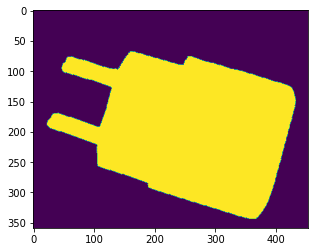

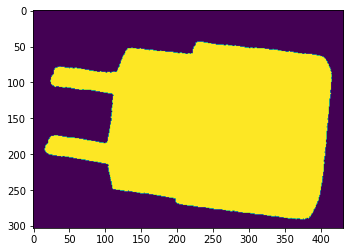

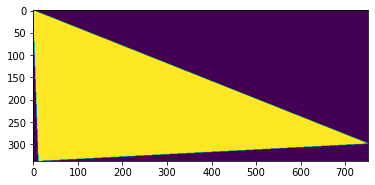

Answer: False


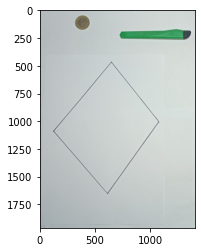

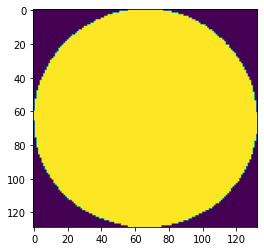

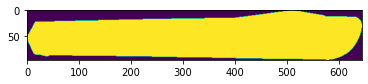

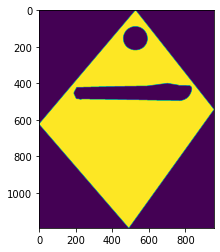

Answer: True


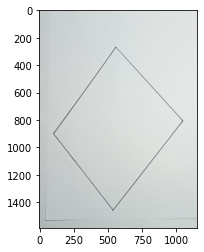

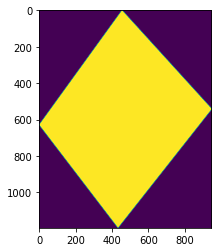

Answer: True


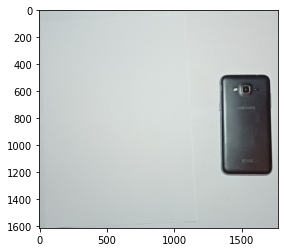

Answer: False


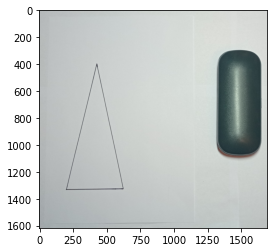

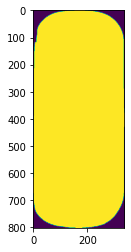

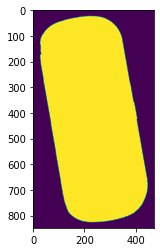

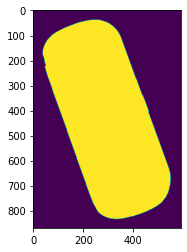

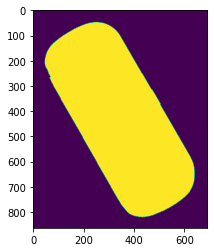

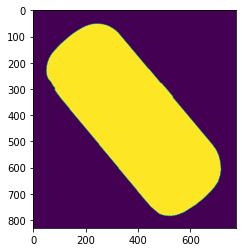

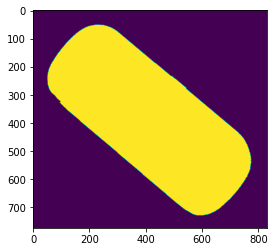

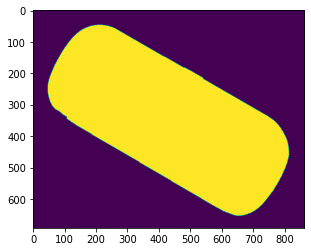

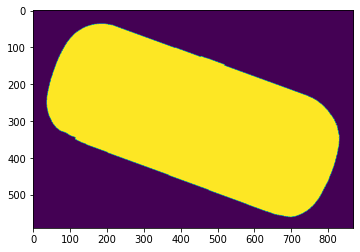

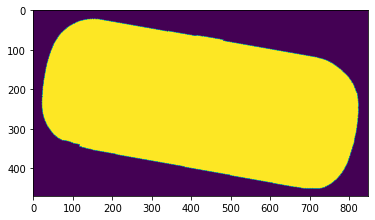

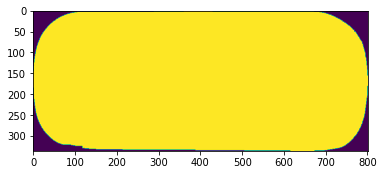

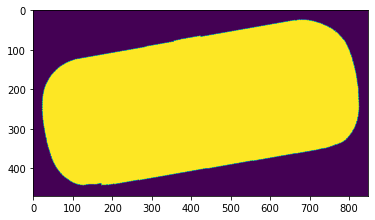

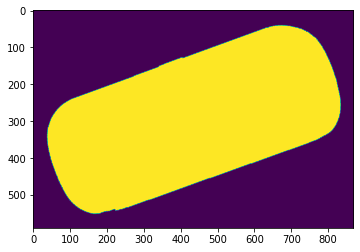

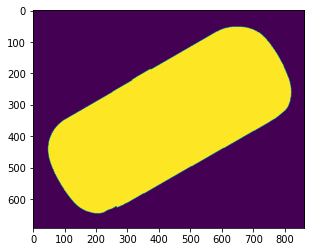

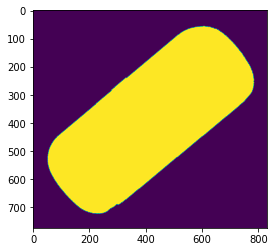

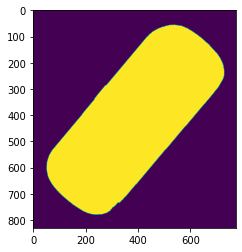

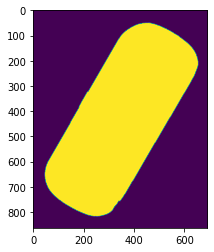

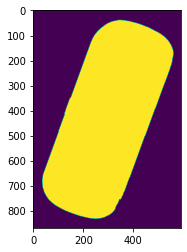

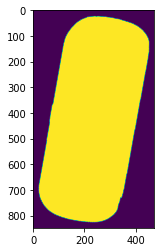

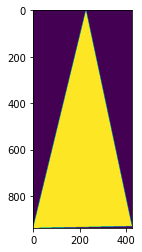

Answer: False


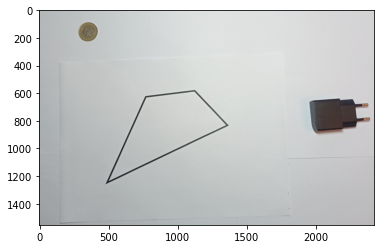

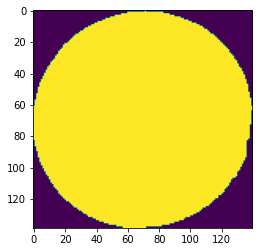

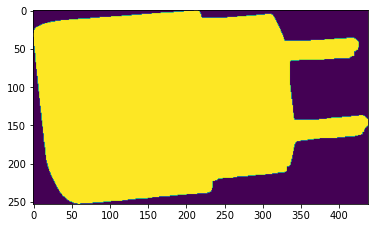

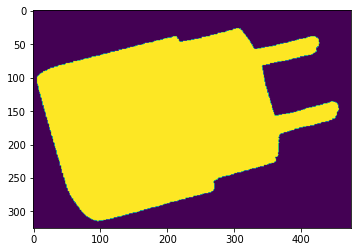

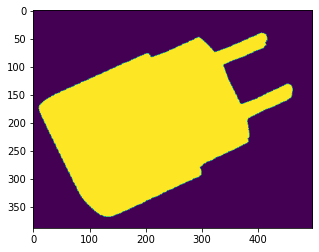

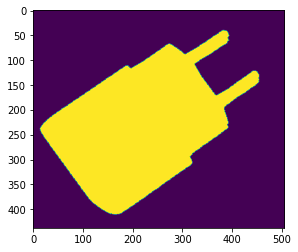

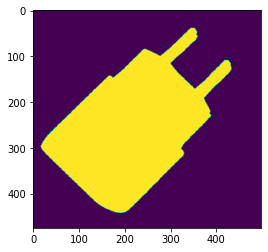

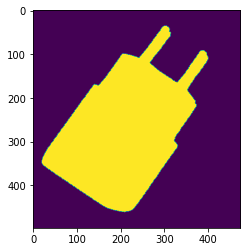

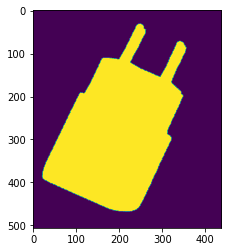

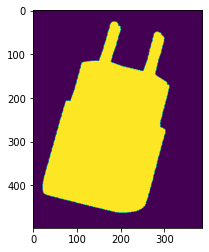

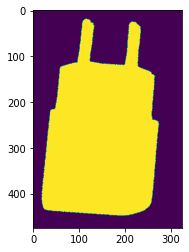

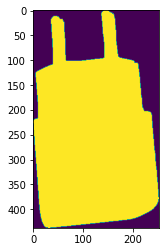

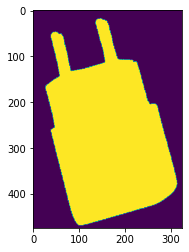

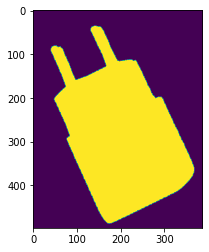

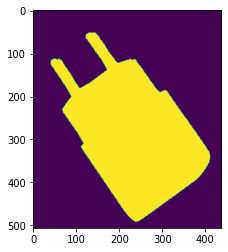

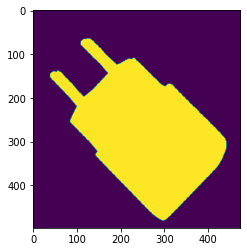

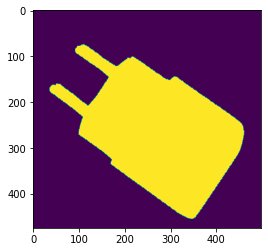

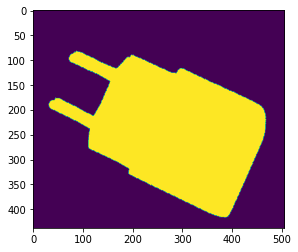

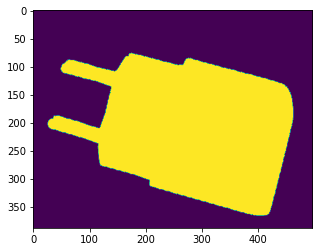

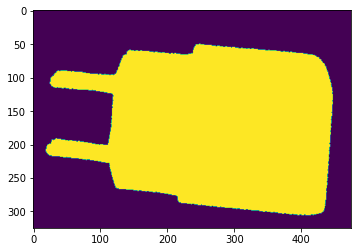

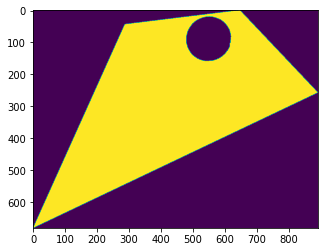

Answer: False


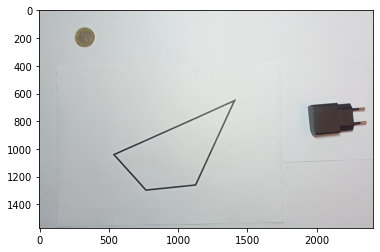

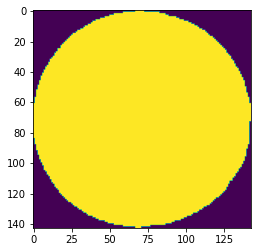

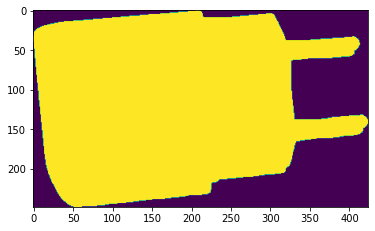

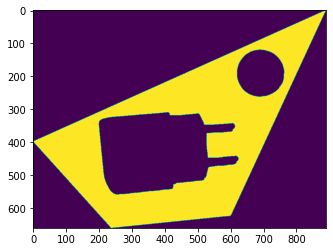

Answer: True


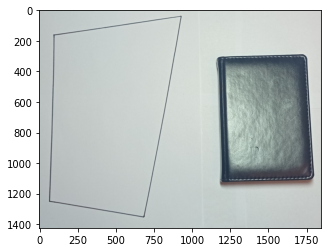

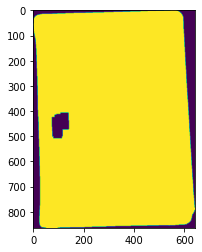

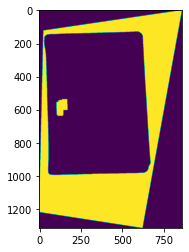

Answer: True


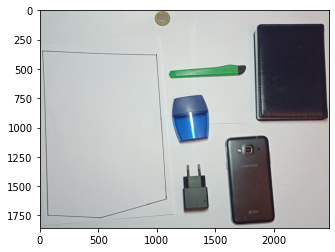

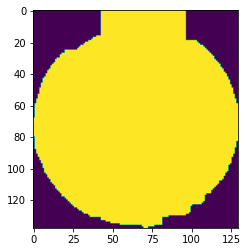

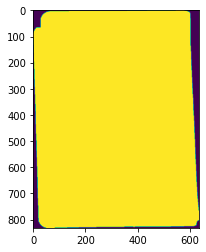

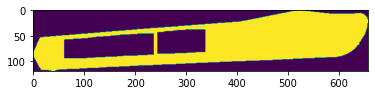

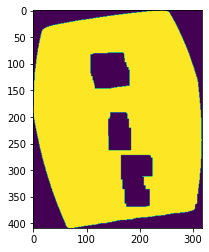

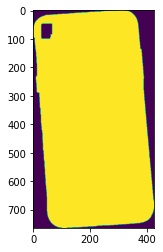

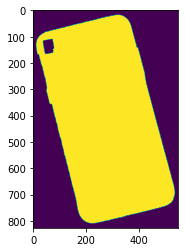

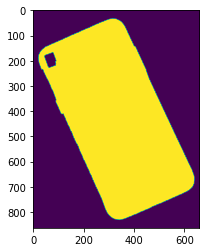

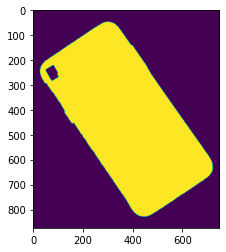

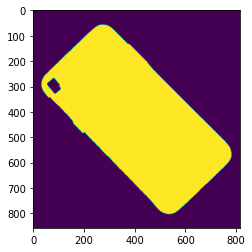

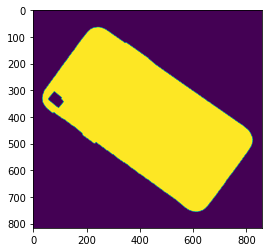

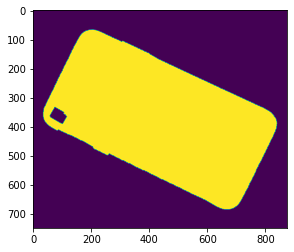

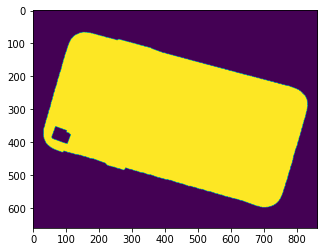

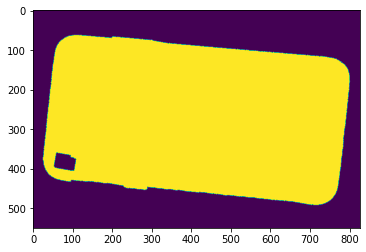

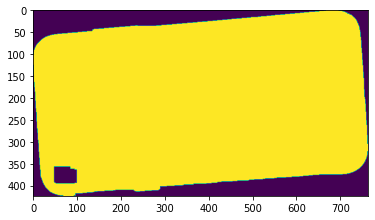

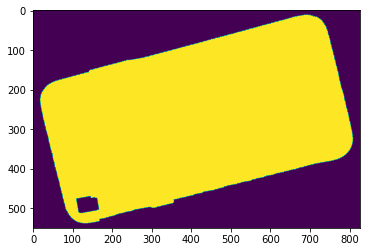

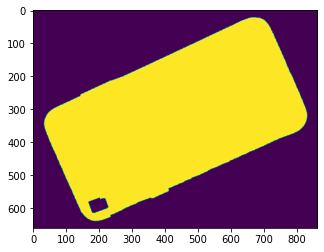

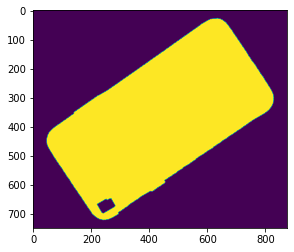

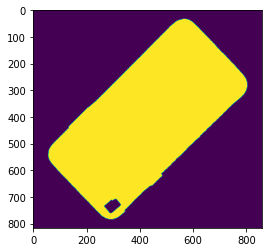

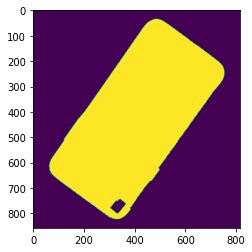

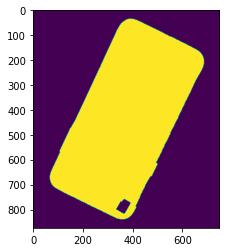

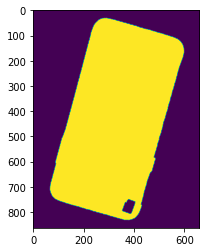

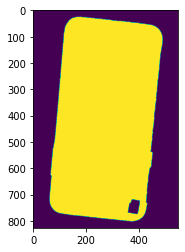

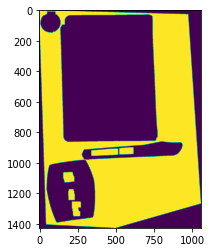

Answer: False


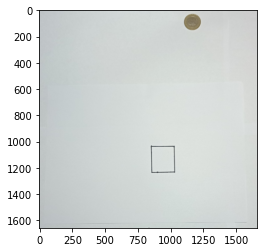

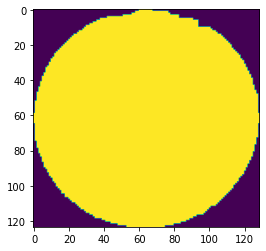

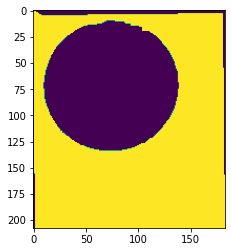

Answer: True


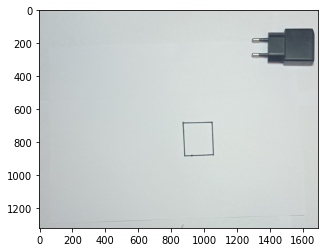

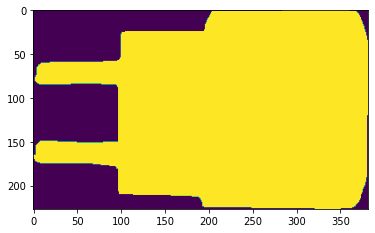

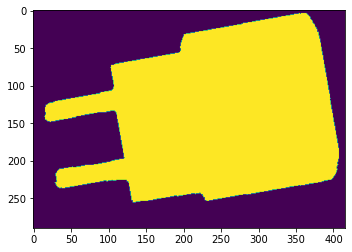

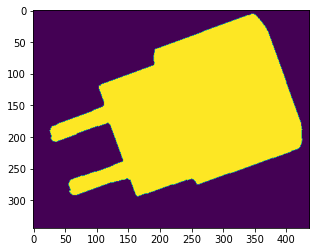

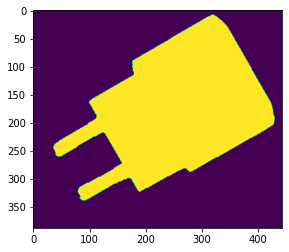

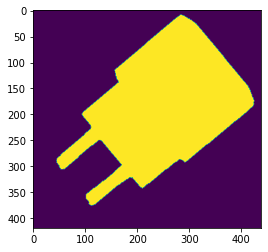

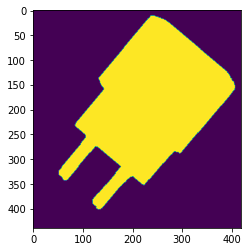

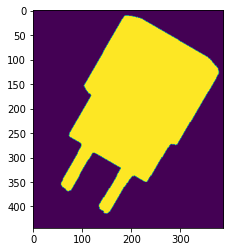

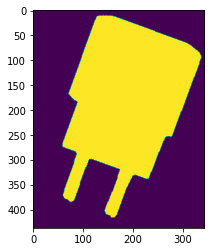

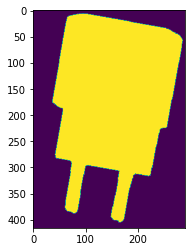

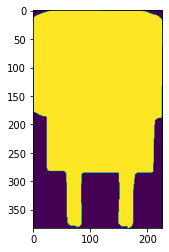

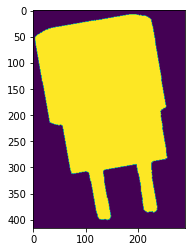

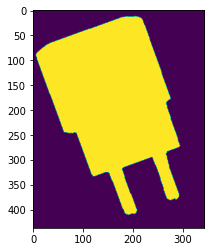

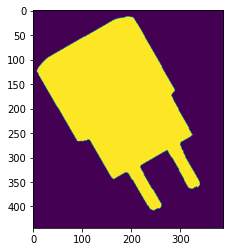

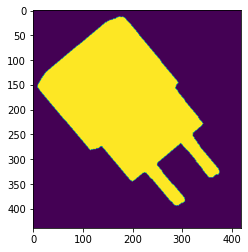

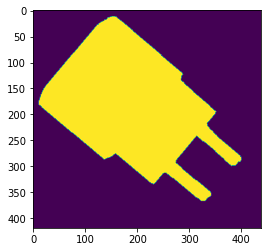

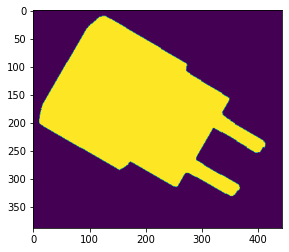

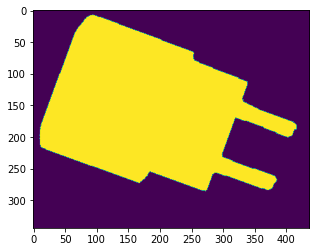

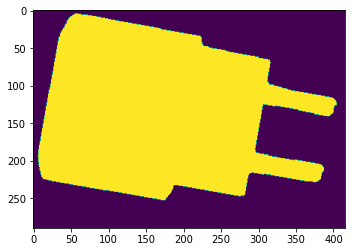

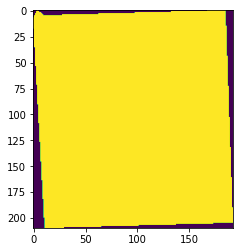

Answer: False


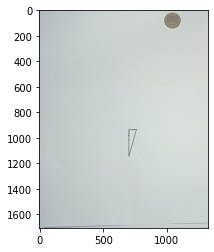

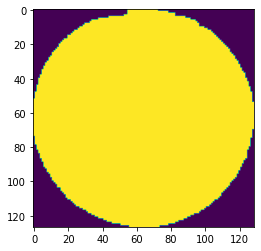

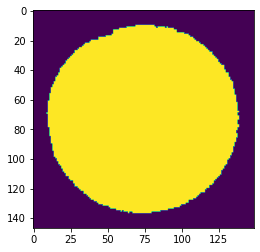

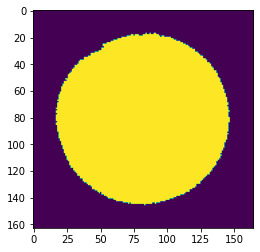

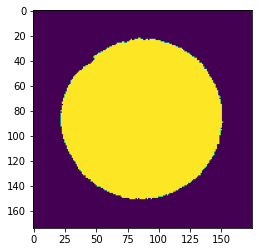

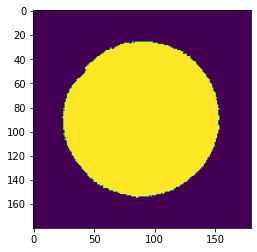

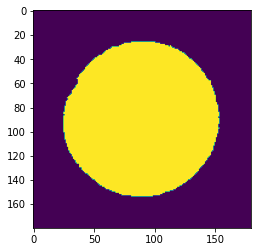

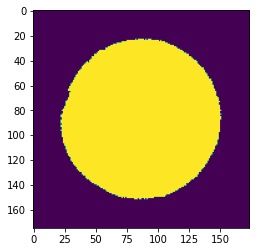

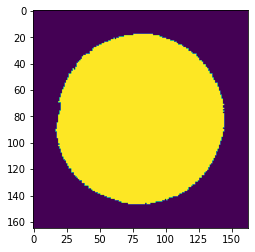

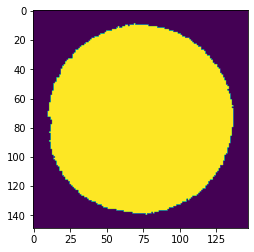

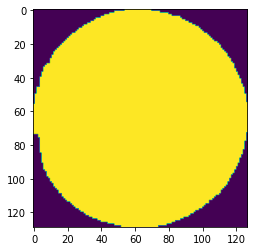

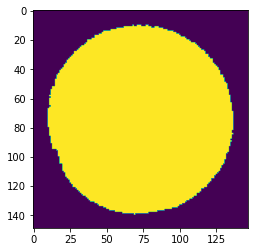

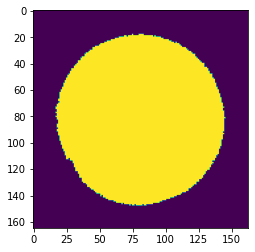

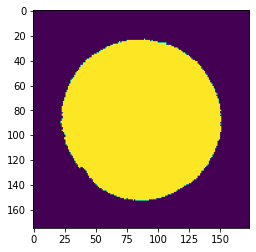

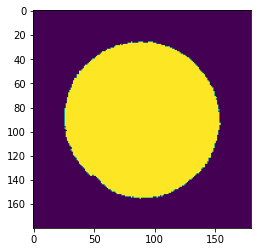

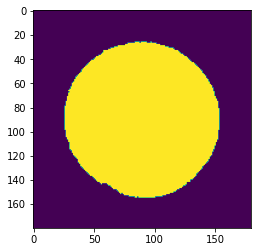

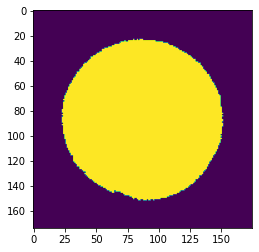

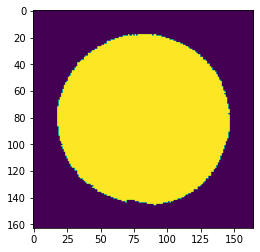

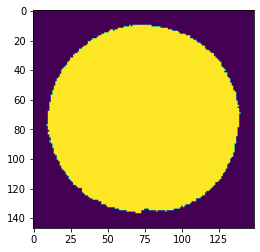

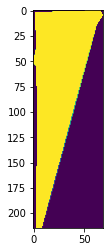

Answer: False


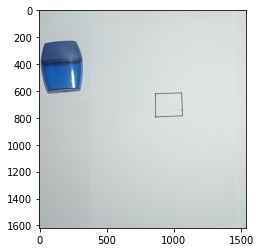

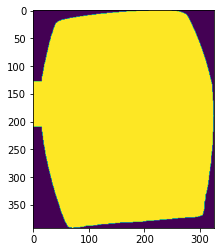

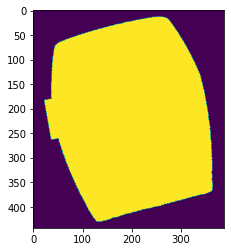

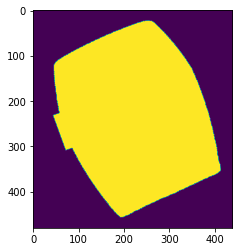

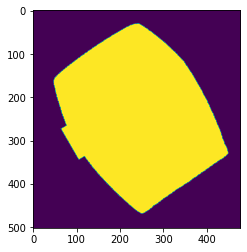

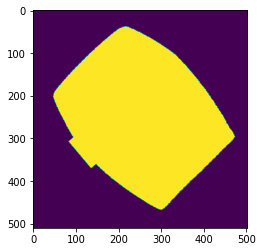

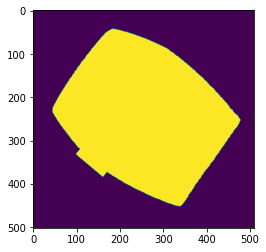

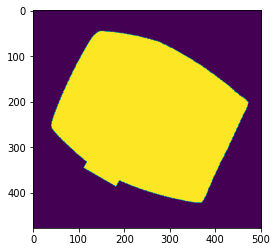

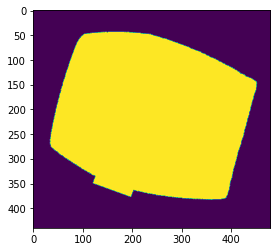

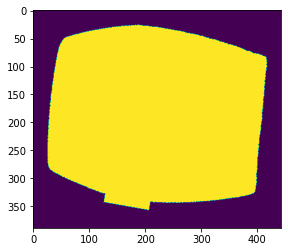

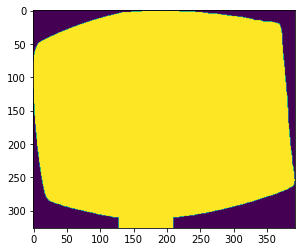

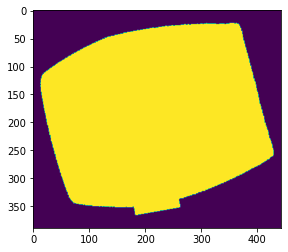

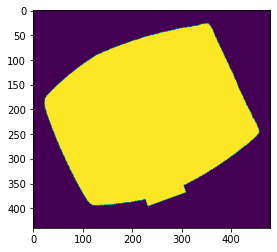

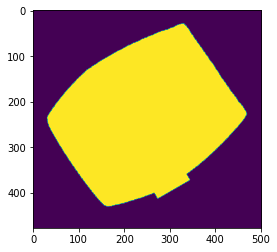

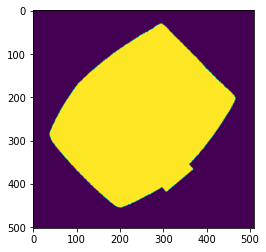

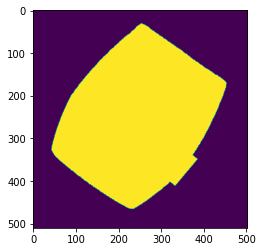

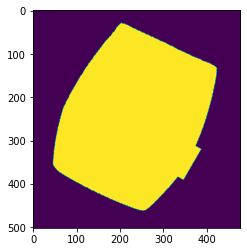

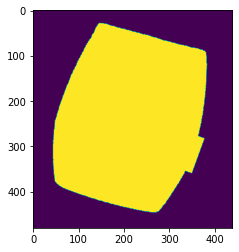

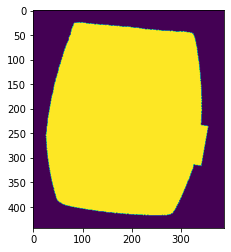

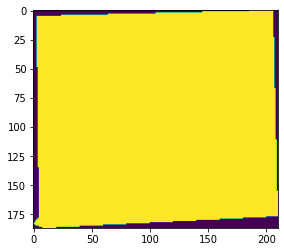

Answer: False


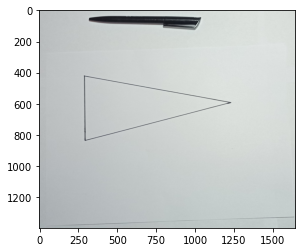

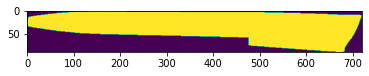

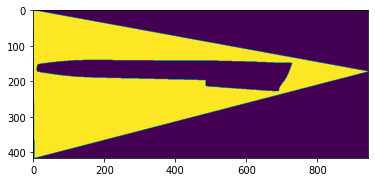

Answer: True


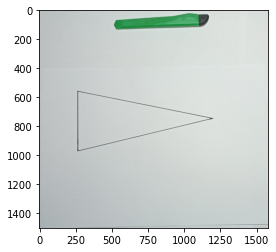

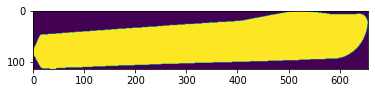

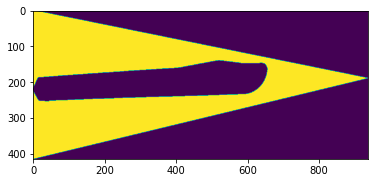

Answer: True


In [4]:
answers = []
for image in im:
    
    plt.imshow(image)
    plt.show()
    
    box, rect = find_poly(image)
    # Если прямоугольник не нашелся - нам некуда складывать предметы, ответ алгоритма - False
    if rect is None:
        print("Answer: False")
        answers.append(False)
        continue
    
    wf = filter_items(image, box)
    masks, areas = get_masks(wf)
    answer, rect = placer(rect, masks, areas)
    answers.append(answer)

    plt.imshow(rect)
    plt.show()
    print(f"Answer: {answer}")

**Теперь давайте построим таблицу предсказанных/реальных значений и посмотрим на некоторые метрики**

In [5]:
import pandas as pd

files = []
for file in os.listdir('tests'):
    if file.endswith(".jpg"):
        files.append(file)
df = pd.read_csv('tests/tests.csv')
real_values = []
row_format ="{:>15}"*3
print(row_format.format("File", "Prediction", "Reality"))
for i, file in enumerate(files):
    algo_answer = answers[i]
    y = df.loc[df['picture'] == str(file),'result'].values[0]
    real_values.append(y)
    print(row_format.format(file, algo_answer, y))


           File     Prediction        Reality
     test_1.jpg              1              1
    test_10.jpg              1              1
    test_11.jpg              0              0
    test_12.jpg              1              1
    test_13.jpg              1              1
    test_14.jpg              0              0
    test_15.jpg              0              0
    test_16.jpg              0              1
    test_17.jpg              1              1
     test_2.jpg              1              1
     test_3.jpg              0              0
     test_4.jpg              1              1
     test_5.jpg              0              0
     test_6.jpg              0              0
     test_7.jpg              0              0
     test_8.jpg              1              1
     test_9.jpg              1              1


*Визулазируем матрицу ошибок*

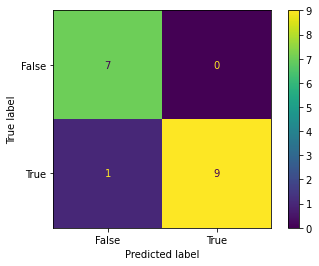

In [6]:

from sklearn import metrics           

conf = metrics.confusion_matrix(real_values, answers)
visualisation = metrics.ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [False, True])
visualisation.plot()

**True Positive, True Negative, False Positive, False Negative:**

In [7]:
true_positive = [file for i, file in enumerate(files) if answers[i] == real_values[i] == 1]
true_negative = [file for i, file in enumerate(files) if answers[i] == real_values[i] == 0]
false_positive = [file for i, file in enumerate(files) if answers[i] == 1 and real_values[i] == 0]
false_negative = [file for i, file in enumerate(files) if answers[i] == 0 and real_values[i] == 1]
TP = len(true_positive)
TN = len(true_negative)
FP = len(false_positive)
FN = len(false_negative)
print("True Positive: ", len(true_positive))
print("True Negative: ", len(true_negative))
print("False Positive:", len(false_positive))
print("False Negative:", len(false_negative))

True Positive:  9
True Negative:  7
False Positive: 0
False Negative: 1


**Accuracy, Recall, Precision**

In [8]:
Accuracy = (TP+TN)/(TP+TN+FP+FN)
Recall = TP/(TP+FN)
Precision = TP/(TP+FP)
print(f"Accuracy: {Accuracy} , Recall: {Recall}, Precision: {Precision}")

Accuracy: 0.9411764705882353 , Recall: 0.9, Precision: 1.0


* Из метрик видим, что алгоритм достаточно хорошо дает правильные ответы(False) для тех предметов, которые нельзя поместить в многоугольники. Однако, из-за жадности алгоритма мы можем пропустить случаи, когда предметы все-таки можно поместить в многоугольник.
* Эта особенность алгоритма хороша видна на тестах 16 и 17, там те же предметы, тот же многоугольник, только по-разному повернут. На одном тесте алгоритм выдает True, на другом False. Рассмотрим работу алгоритма подробнее, чтобы понять, в чем тут дело. Алгоритм в обоих случаях сначала прикладывает первую маску - монету - в обоих случаях она помещается. Дальше он пытается приложить зарядку, и тут, в зависимости от поворота многоугольника, она может поместиться, а может нет. Если бы это был полный перебор, она бы в любом случае поместилась - мы бы продолжили поиск, начав укладку теперь с зарядки. Но жадный алгоритм, как только не может разместить предмет, сразу выдает False, завершая свою работу.
* Вместо жадного алгоритма можно использовать полный перебор, однако, он сильно увеличит время работы программы. Поэтому, как идею улучшения, можно рассмотреть различные эвристики. Например, идею размещать сначала предметы с углом "подобным" (похожим по какой-то метрике) какому-то углу многоугольника. Мы легко можем аппроксимировать каждый предмет многоугольником встроенными средствами, а затем найти его внутренние углы (через скалярное произведение). Рассмотрим это на примере 16 и 17 теста: в многоугольнике есть угол, близкий к 90&deg;, подобный угол имеется у зарядки, но не у монеты (там все углы будут близки 180&deg;). Размещая зарядку к этому углу, мы всегда сможем затем поместить монету. Разумеется, это всего лишь эвристика, и она не гарантирует точное/оптимальное решение, но в каких-то случаях она дает верный результат